In [1]:
#%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from scipy.ndimage import find_objects
from matplotlib.colors import Normalize
from src.cpm_basic import CellularPottsModel

# Time Development 

In [ ]:
n_cells=38
n_types=2 
T=26 
L=100
C_p=1
adhessions= np.array([[0, 0.2, 0.2],  
                      [0.2, 10, 20],
                      [0.2, 20, 10]]) 
volume_coefficient= np.array([0, 10, 10])
lattice_type="prerun"
object_volumes=None # Is default set in the CPM class if none
periodic=False

In [3]:
init = ["hex", "prerun", "circle"]
energies = []

for i in init:
    cpm = CellularPottsModel(n_cells=n_cells, n_types=n_types, T=T, L=L, C_p=C_p, volume_coefficient=volume_coefficient,
                             adhessions=adhessions, lattice_type=i, object_volumes=object_volumes, periodic=periodic)
    energy = cpm.run_time_development_sim(steps=500000, interval=1000)
    energies.append(energy)

100%|██████████| 500000/500000 [01:37<00:00, 5151.18it/s]


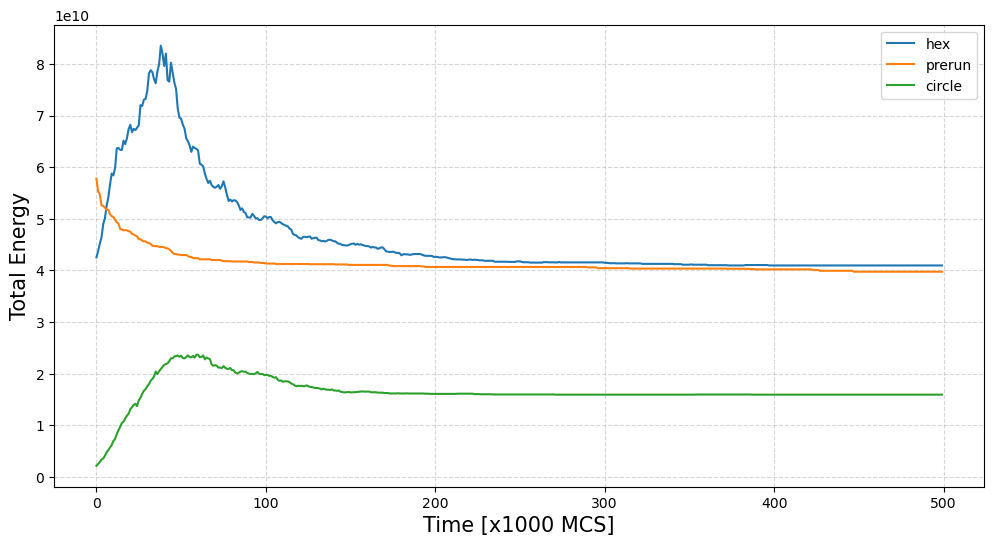

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))


for i, energy in enumerate(energies):
    ax.plot(energy, label=init[i])
ax.set_xlabel("Time [x1000 MCS]", fontsize=15)
ax.set_ylabel("Total Energy", fontsize=15)
ax.legend()
ax.grid(linestyle='--', alpha=0.5)
plt.show()